In [1]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 3.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
BASE = '../input/godaddy-microbusiness-density-forecasting/'

def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap


!ls ../input/godaddy-microbusiness-density-forecasting

census_starter.csv  sample_submission.csv  test.csv  train.csv


In [2]:
census = pd.read_csv(BASE + 'census_starter.csv')
print(census.columns)
census.head()

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')


,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [3]:
train = pd.read_csv(BASE + 'train.csv')
test = pd.read_csv(BASE + 'test.csv')
sub = pd.read_csv(BASE + 'sample_submission.csv')
print(train.shape, test.shape, sub.shape)

train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True)


raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw.tail(20)

(122265, 7) (25080, 3) (25080, 2)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
147325,56045_2021-11-01,56045,Weston County,Wyoming,2021-11-01,1.760374,98.0,0,2021,11,27,3134,50
147326,56045_2021-12-01,56045,Weston County,Wyoming,2021-12-01,1.796300,100.0,0,2021,12,28,3134,50
147327,56045_2022-01-01,56045,Weston County,Wyoming,2022-01-01,1.749688,98.0,0,2022,1,29,3134,50
147328,56045_2022-02-01,56045,Weston County,Wyoming,2022-02-01,1.749688,98.0,0,2022,2,30,3134,50
147329,56045_2022-03-01,56045,Weston County,Wyoming,2022-03-01,1.767542,99.0,0,2022,3,31,3134,50
147330,56045_2022-04-01,56045,Weston County,Wyoming,2022-04-01,1.767542,99.0,0,2022,4,32,3134,50
147331,56045_2022-05-01,56045,Weston County,Wyoming,2022-05-01,1.803249,101.0,0,2022,5,33,3134,50
147332,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101.0,0,2022,6,34,3134,50
147333,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101.0,0,2022,7,35,3134,50
147334,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100.0,0,2022,8,36,3134,50


# There are some anomalies, specially at timestep 18

<AxesSubplot:xlabel='dcount'>

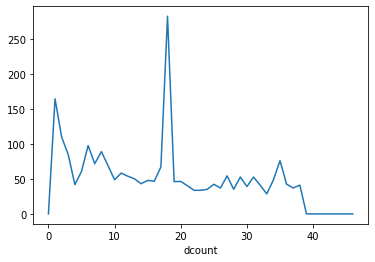

In [4]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

In [5]:
outliers = []
cnt = 0
for o in tqdm(raw.cfips.unique()):
    indices = (raw['cfips']==o)
    tmp = raw.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
    #vmax = np.max(var[:38]) - np.min(var[:38])
    
    for i in range(37, 2, -1):
        thr = 0.20*np.mean(var[:i])
        difa = abs(var[i]-var[i-1])
        if (difa>=thr):
            var[:i] *= (var[i]/var[i-1])
            outliers.append(o)
            cnt+=1
    var[0] = var[1]*0.99
    raw.loc[indices, 'microbusiness_density'] = var
    
outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


(481, 732)

<AxesSubplot:xlabel='dcount'>

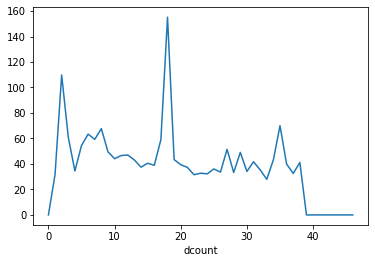

In [6]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

<AxesSubplot:xlabel='dcount'>

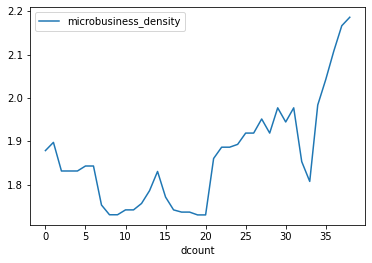

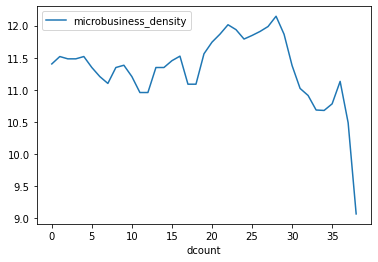

In [7]:
raw.loc[raw.cfips == 1013].plot(x='dcount', y='microbusiness_density')
raw.loc[raw.cfips == 21215].plot(x='dcount', y='microbusiness_density')

# SMAPE is a relative metric so target must be converted.

In [8]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)
raw['target'] = raw['target']/raw['microbusiness_density'] - 1

raw.loc[raw['cfips']==28055, 'target'] = 0.0
raw.loc[raw['cfips']==48269, 'target'] = 0.0

raw.iloc[-20:,:20]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif,target
147325,56045_2021-11-01,56045,Weston County,Wyoming,2021-11-01,1.760374,98.0,0,2021,11,27,3134,50,1.670559,0.053763,0.020408
147326,56045_2021-12-01,56045,Weston County,Wyoming,2021-12-01,1.796300,100.0,0,2021,12,28,3134,50,1.760374,0.020408,-0.025949
147327,56045_2022-01-01,56045,Weston County,Wyoming,2022-01-01,1.749688,98.0,0,2022,1,29,3134,50,1.796300,0.025949,0.000000
147328,56045_2022-02-01,56045,Weston County,Wyoming,2022-02-01,1.749688,98.0,0,2022,2,30,3134,50,1.749688,0.000000,0.010204
147329,56045_2022-03-01,56045,Weston County,Wyoming,2022-03-01,1.767542,99.0,0,2022,3,31,3134,50,1.749688,0.010204,0.000000
147330,56045_2022-04-01,56045,Weston County,Wyoming,2022-04-01,1.767542,99.0,0,2022,4,32,3134,50,1.767542,0.000000,0.020202
147331,56045_2022-05-01,56045,Weston County,Wyoming,2022-05-01,1.803249,101.0,0,2022,5,33,3134,50,1.767542,0.020202,0.000000
147332,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101.0,0,2022,6,34,3134,50,1.803249,0.000000,0.000000
147333,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101.0,0,2022,7,35,3134,50,1.803249,0.000000,-0.009901
147334,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100.0,0,2022,8,36,3134,50,1.803249,0.009901,0.000000


<AxesSubplot:>

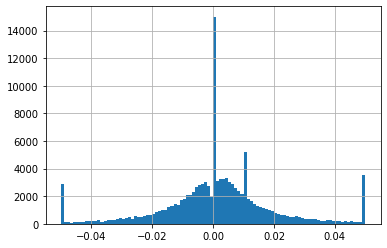

In [9]:
raw['target'].clip(-0.05, 0.05).hist(bins=100)

<AxesSubplot:>

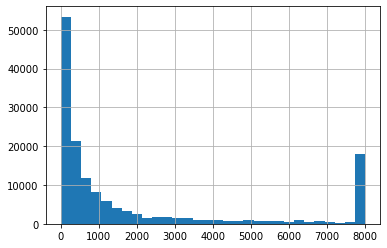

In [10]:
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')

dt = raw.loc[raw.dcount==28].groupby('cfips')['microbusiness_density'].agg('last')
raw['lasttarget'] = raw['cfips'].map(dt)

raw['lastactive'].clip(0, 8000).hist(bins=30)

# Feature Engineering

In [11]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []
    for lag in range(1, lags):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        #raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        feats.append(f'mbd_rollmea{window}_{lag}')
        
    return raw, feats

In [12]:
# Build Features based in lag of target
raw, feats = build_features(raw, 'target', 'active', lags = 4)
features = ['state_i']
features += feats
print(features)
raw.loc[raw.dcount==38, features].head(10)

['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1']


,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1
38,0,0.006152,9.0,0.005498,17.0,-0.004107,11.0,0.011650,0.034969,0.027467
85,0,0.002170,31.0,-0.017601,-225.0,-0.009601,-366.0,-0.015431,-0.017278,0.049618
132,0,0.020921,5.0,0.008439,7.0,-0.016597,3.0,0.029359,0.033948,0.033966
179,0,-0.021367,-5.0,0.017391,-1.0,-0.025424,-7.0,-0.003976,0.010248,0.028286
226,0,-0.010949,-9.0,0.008589,-2.0,0.002460,0.0,-0.002360,0.033137,0.038372
273,0,0.012987,1.0,0.013158,2.0,0.013333,3.0,0.026145,0.052992,0.080770
320,0,0.009036,3.0,0.027864,12.0,0.031949,22.0,0.036900,0.098454,0.171279
367,0,-0.003180,-8.0,0.007609,11.0,0.002006,16.0,0.004429,0.027747,0.034010
414,0,-0.040201,-16.0,-0.012407,-21.0,-0.017073,-28.0,-0.052608,-0.015697,-0.023285
461,0,-0.012605,-3.0,0.000000,-3.0,-0.008333,-5.0,-0.012605,0.000338,-0.098884


<AxesSubplot:>

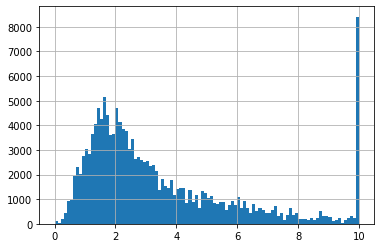

In [13]:
raw['lasttarget'].clip(0,10).hist(bins=100)

In [14]:
blacklist = [
    'North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont'
]
blacklistcfips = [
1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1077,1085,1091,1099,1101,1123,1131,1133,4001,4012,4013,4021,4023,5001,5003,5005,5017,5019,5027,5031,5035,5047,5063,5065,5071,5081,5083,5087,5091,5093,5107,5109,5115,5121,5137,5139,5141,5147,6003,6015,6027,6033,6053,6055,6057,6071,6093,6097,6103,6105,6115,8003,8007,8009,8019,8021,8023,8047,8051,8053,8055,8057,8059,8061,8065,8067,8069,8071,8073,8075,8085,8091,8093,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,9007,9009,9015,12009,12017,12019,12029,12047,12055,12065,12075,12093,12107,12127,13005,13007,13015,13017,13019,13027,13035,13047,13065,13081,13083,13099,13107,13109,13117,13119,13121,13123,13125,13127,13135,13143,13147,13161,13165,13171,13175,13181,13193,13201,13221,13225,13229,13231,13233,13245,13247,13249,13257,13279,13281,13287,13289,13293,13301,13319,15001,15005,15007,16001,16003,16005,16007,16013,16015,16017,16023,16025,16029,16031,16033,16035,16037,16043,16045,16049,16061,16063,16067,17001,17003,17007,17009,17013,17015,17023,17025,17031,17035,17045,17051,17059,17061,17063,17065,17067,17069,17075,17077,17081,17085,17087,17103,17105,17107,17109,17115,17117,17123,17127,17133,17137,17141,17143,17147,17153,17167,17169,17171,17177,17179,17181,17185,17187,17193,18001,18007,18009,18013,18015,18019,18021,18025,18035,18037,18039,18041,18053,18061,18075,18079,18083,18087,18099,18103,18111,18113,18115,18137,18139,18145,18153,18171,18179,21001,21003,21013,21017,21023,21029,21035,21037,21039,21045,21047,21055,21059,21065,21075,21077,21085,21091,21093,21097,21099,21101,21103,21115,21125,21137,21139,21141,21149,21155,21157,21161,21165,21179,21183,21191,21197,21199,21215,21217,21223,21227,21237,21239,22019,22021,22031,22039,22041,22047,22069,22085,22089,22101,22103,22109,22111,22115,22119,22121,23003,23009,23021,23027,23029,24011,24027,24029,24031,24035,24037,24039,24041,25011,25015,26003,26007,26011,26019,26021,26025,26027,26033,26037,26041,26043,26051,26053,26057,26059,26061,26065,26071,26077,26079,26083,26089,26097,26101,26103,26109,26111,26115,26117,26119,26127,26129,26131,26135,26141,26143,26155,26161,26165,27005,27011,27013,27015,27017,27021,27023,27025,27029,27047,27051,27055,27057,27065,27069,27073,27075,27077,27079,27087,27091,27095,27101,27103,27105,27107,27109,27113,27117,27119,27123,27125,27129,27131,27133,27135,27141,27147,27149,27155,27159,27167,27169,28017,28019,28023,28025,28035,28045,28049,28061,28063,28093,28097,28099,28125,28137,28139,28147,28159,29001,29015,29019,29031,29033,29041,29049,29051,29055,29057,29063,29065,29069,29075,29085,29089,29101,29103,29111,29121,29123,29125,29135,29137,29139,29143,29157,29159,29161,29167,29171,29173,29175,29177,29183,29195,29197,29199,29203,29205,29207,29209,29213,29215,29217,29223,29227,29229,30005,30009,30025,30027,30033,30035,30037,30039,30045,30049,30051,30053,30055,30057,30059,30069,30071,30073,30077,30079,30083,30085,30089,30091,30093,30101,30103,30105,30107,30109,32005,32009,32017,32023,32027,32029,32510,33005,33007,34021,34027,34033,34035,36011,36017,36023,36033,36043,36047,36049,36051,36057,36061,36067,36083,36091,36097,36103,36107,36113,36115,36121,36123,37005,37009,37011,37017,37023,37029,37031,37049,37061,37075,37095,37117,37123,37131,37137,37151,37187,37189,37197,39005,39009,39015,39017,39019,39023,39037,39039,39043,39049,39053,39057,39063,39067,39071,39077,39085,39087,39091,39097,39105,39107,39113,39117,39119,39125,39127,39129,39135,39137,39151,39153,39157,40003,40013,40015,40023,40025,40027,40035,40039,40043,40045,40053,40055,40057,40059,40065,40067,40073,40077,40079,40099,40105,40107,40111,40115,40123,40127,40129,40133,40141,40147,40151,40153,41001,41007,41013,41015,41017,41021,41025,41031,41033,41037,41051,41055,41063,41067,41069,42005,42007,42011,42013,42015,42019,42027,42029,42031,42035,42053,42057,42067,42071,42083,42085,42093,42097,42105,42111,42113,42115,42123,42125,42127,42129,44005,44007,44009,45001,45009,45021,45025,45031,45059,45067,45071,45073,45089,47001,47005,47013,47015,47019,47021,47023,47027,47035,47039,47041,47047,47055,47057,47059,47061,47069,47073,47075,47077,47083,47087,47099,47105,47121,47127,47131,47133,47135,47137,47147,47151,47153,47159,47161,47163,47169,47177,47183,47185,48001,48011,48017,48019,48045,48057,48059,48063,48065,48073,48077,48079,48081,48083,48087,48095,48101,48103,48107,48109,48115,48117,48119,48123,48125,48129,48149,48151,48153,48155,48159,48161,48165,48175,48189,48191,48195,48197,48211,48221,48229,48233,48235,48237,48239,48241,48243,48245,48255,48261,48263,48265,48267,48269,48275,48277,48283,48293,48299,48305,48311,48313,48319,48321,48323,48327,48333,48345,48347,48355,48369,48377,48379,48383,48387,48389,48401,48403,48413,48417,48431,48433,48437,48443,48447,48453,48455,48457,48461,48463,48465,48469,48471,48481,48483,48485,48487,48495,48499,49001,49009,49013,49019,49027,49031,49045,51005,51017,51025,51029,51031,51036,51037,51043,51057,51059,51065,51071,51073,51077,51079,51083,51091,51095,51097,51101,51111,51115,51119,51121,51127,51135,51147,51155,51159,51165,51167,51171,51173,51181,51183,51191,51197,51530,51590,51610,51620,51670,51678,51720,51735,51750,51770,51810,51820,53013,53019,53023,53031,53033,53037,53039,53041,53047,53065,53069,53071,53075,54013,54019,54025,54031,54033,54041,54049,54055,54057,54063,54067,54071,54077,54079,54085,54089,54103,55001,55003,55005,55007,55011,55017,55021,55025,55029,55037,55043,55047,55049,55051,55061,55065,55067,55075,55077,55091,55097,55101,55103,55109,55117,55123,55125,55127,56007,56009,56011,56015,56017,56019,56021,56027,56031,56037,56043,56045,
12061,  6095, 49025, 18073, 29029, 29097, 48419, 51830, 30067, 26095, 18159, 32001, 54065, 54027, 13043, 48177, 55069, 48137, 30087, 29007, 13055, 48295, 28157, 29037, 45061, 22053, 13199, 47171, 53001, 55041, 51195, 18127, 29151, 48307, 51009, 16047, 29133,  5145, 17175, 21027, 48357, 29179, 13023, 16077, 48371, 21057, 16039, 21143, 48435, 48317, 48475,  5129, 36041, 48075, 29017, 47175, 39167, 47109, 17189, 17173, 28009, 39027, 48133, 18129, 48217, 40081, 36021,  6005, 42099, 18051, 36055, 53051, 6109, 21073, 27019,  6051, 48055,  8083, 48503, 17021, 10003, 41061, 22001, 22011, 21205, 48223, 51103, 51047, 16069, 17033, 41011,  6035, 47145, 27083, 18165, 36055, 12001, 26159,  8125, 34017,
28141, 55119, 48405, 40029, 18125, 21135, 29073, 55115, 37149,55039, 26029, 12099, 13251, 48421, 39007, 41043, 22015, 37115,54099, 51137, 22049, 55131, 17159, 56001, 40005, 18017, 28091,47101, 27037, 29005, 13239, 21019, 55085, 48253, 51139, 40101,13283, 18049, 39163, 45049, 51113,
]
ACT_THR = 1.8
ABS_THR = 1.00
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.
VAL = []
BEST_ROUNDS = []
for TS in range(29, 38):
    print(TS)
    
    model = xgb.XGBRegressor(
        objective='reg:pseudohubererror',
        #objective='reg:squarederror',
        tree_method="hist",
        n_estimators=4999,
        learning_rate=0.0075,
#         max_leaves = 17,
        max_leaves = 20,
        subsample=0.50,
        colsample_bytree=0.50,
        max_bin=4096,
        n_jobs=2,
        eval_metric='mae',
        early_stopping_rounds=70,
    )
            
    train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) 
    valid_indices = (raw.istest==0) & (raw.dcount == TS)
    model.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
        eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
        verbose=500,
    )
    best_rounds = model.best_iteration
    BEST_ROUNDS.append(model.best_iteration)
    ypred = model.predict(raw.loc[valid_indices, features])
    raw.loc[valid_indices, 'k'] = ypred + 1
    raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

    # Validate
    lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    
    df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    df['pred'] = df['cfips'].map(dt)
    df['lastval'] = df['cfips'].map(lastval)
    
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
    df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
    df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
    df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
    raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
    
    print(f'TS: {TS}')
    print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )
    print('XGB SMAPE:', smape(df['microbusiness_density'], df['pred']))
    print()


ind = (raw.dcount>=30)&(raw.dcount<=38)
print( 'XGB SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred'] ) )
print( 'Last Value SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred_last'] ) )

29
[0]	validation_0-mae:0.49351
[500]	validation_0-mae:0.01429
[889]	validation_0-mae:0.01090
TS: 29
Last Value SMAPE: 1.0868726017655663
XGB SMAPE: 1.0731252852410869

30
[0]	validation_0-mae:0.48746
[500]	validation_0-mae:0.01257
[640]	validation_0-mae:0.01205
TS: 30
Last Value SMAPE: 1.318087470449913
XGB SMAPE: 1.1470042805618776

31
[0]	validation_0-mae:0.49315
[500]	validation_0-mae:0.01466
[938]	validation_0-mae:0.01117
TS: 31
Last Value SMAPE: 1.1258309832479911
XGB SMAPE: 1.1062827768627

32
[0]	validation_0-mae:0.49995
[500]	validation_0-mae:0.01701
[1000]	validation_0-mae:0.00927
[1500]	validation_0-mae:0.00911
[2000]	validation_0-mae:0.00910
[2500]	validation_0-mae:0.00909
[3000]	validation_0-mae:0.00909
[3305]	validation_0-mae:0.00909
TS: 32
Last Value SMAPE: 0.897969439640235
XGB SMAPE: 0.9059920219543192

33
[0]	validation_0-mae:0.48932
[500]	validation_0-mae:0.01449
[680]	validation_0-mae:0.01329
TS: 33
Last Value SMAPE: 1.3686285670946152
XGB SMAPE: 1.2613685704927329


In [15]:
raw['error'] = vsmape(raw['microbusiness_density'], raw['ypred'])
raw['error_last'] = vsmape(raw['microbusiness_density'], raw['ypred_last'])
raw.loc[(raw.dcount==30), ['microbusiness_density', 'ypred', 'error', 'error_last'] ]

,microbusiness_density,ypred,error,error_last
30,3.334431,3.301487,0.992922,1.135557
77,7.823300,7.737346,1.104755,1.155810
124,1.206827,1.187882,1.582236,1.687769
171,1.236650,1.215938,1.688977,1.834867
218,1.777708,1.754370,1.321480,1.403959
...,...,...,...,...
147140,2.892446,2.926768,1.179620,1.179620
147187,25.438322,25.551734,0.444838,0.368550
147234,3.954258,3.758325,5.080841,5.183206
147281,3.027295,3.027295,0.000000,0.000000


In [16]:
# dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('state')['error', 'error_last'].mean()
# dt['hit'] = dt['error'] - dt['error_last']
# dt = dt.sort_values('hit', ascending=True)
# dt

In [17]:
# dt.index[-8:]

In [18]:
# dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('dcount')['error', 'error_last'].mean()
# dt['hit'] = dt['error'] - dt['error_last']
# dt = dt.sort_values('hit', ascending=False)
# dt.loc[dt['hit']>0]
# dt

In [19]:
# dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].mean()
# dt['hit'] = dt['error'] - dt['error_last']
# dt = dt.sort_values('hit', ascending=False).reset_index()
# dt.loc[dt['hit']>0]
# dt

In [20]:
# dt.loc[dt['hit']>0].cfips.values[:300]

In [21]:
# dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby('cfips')['error', 'error_last'].mean()
# dt['hit'] = dt['error'] - dt['error_last']
# dt = dt.sort_values('hit', ascending=False)
# dt = dt.loc[dt['hit']>0.00]
# dt

In [22]:
# dt.index

In [23]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].last()
dt['miss'] = dt['error'] > dt['error_last']
dt = dt.groupby('cfips')['miss'].mean()
dt = dt.loc[dt>=0.50]
dt.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


(7,)

In [24]:
len(dt.index)

7

In [25]:
','.join([str(i) for i in dt.index])

'6021,8049,13213,48259,48385,48449,55045'

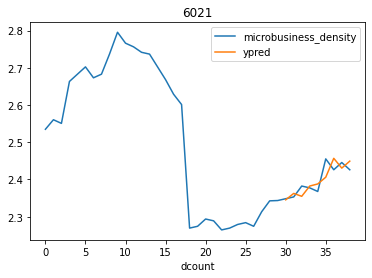

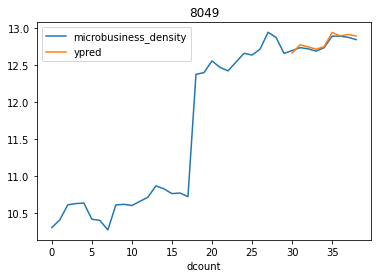

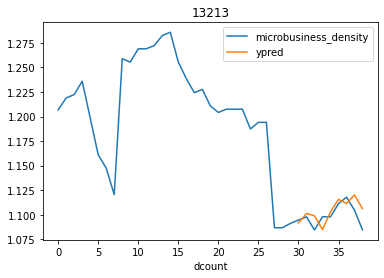

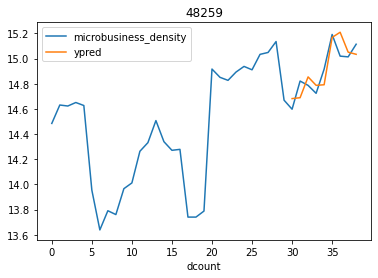

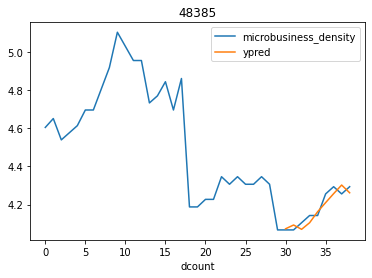

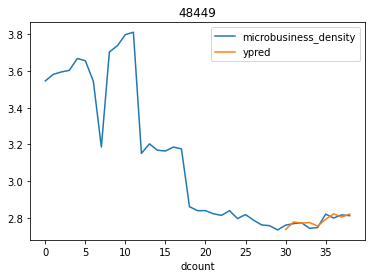

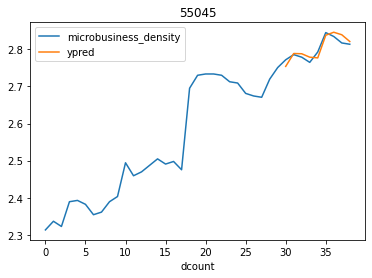

In [26]:
for d in dt.index[:10]:
    raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred'], title=str(d))

In [27]:
# df = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].copy().reset_index(drop=True)
# print( smape(df['microbusiness_density'], df['ypred']) )

# dt = df.groupby(['cfips','dcount'])['error', 'error_last'].sum()
# dt['hit'] = 1*(dt['error'] < dt['error_last'])
# dt = dt.groupby('cfips')['hit'].mean().sort_values(ascending=True)

# toplist = list(dt.index[:800])
# #print(toplist)
# df.loc[df.cfips.isin(toplist), 'ypred'] = df.loc[df.cfips.isin(toplist), 'ypred_last']
# print( smape(df['microbusiness_density'], df['ypred']) )

In [28]:
raw.iloc[-40:, :16]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif,target
147305,56045_2020-03-01,56045,Weston County,Wyoming,2020-03-01,1.537087,86.0,0,2020,3,7,3134,50,0.011765,0.011765,0.011628
147306,56045_2020-04-01,56045,Weston County,Wyoming,2020-04-01,1.554960,87.0,0,2020,4,8,3134,50,0.011628,0.011628,0.034483
147307,56045_2020-05-01,56045,Weston County,Wyoming,2020-05-01,1.608579,90.0,0,2020,5,9,3134,50,0.034483,0.034483,0.033333
147308,56045_2020-06-01,56045,Weston County,Wyoming,2020-06-01,1.662198,93.0,0,2020,6,10,3134,50,0.033333,0.033333,-0.064516
147309,56045_2020-07-01,56045,Weston County,Wyoming,2020-07-01,1.554960,87.0,0,2020,7,11,3134,50,-0.064516,0.064516,0.022989
147310,56045_2020-08-01,56045,Weston County,Wyoming,2020-08-01,1.590706,89.0,0,2020,8,12,3134,50,0.022989,0.022989,0.000000
147311,56045_2020-09-01,56045,Weston County,Wyoming,2020-09-01,1.590706,89.0,0,2020,9,13,3134,50,0.000000,0.000000,-0.022472
147312,56045_2020-10-01,56045,Weston County,Wyoming,2020-10-01,1.554960,87.0,0,2020,10,14,3134,50,-0.022472,0.022472,0.000000
147313,56045_2020-11-01,56045,Weston County,Wyoming,2020-11-01,1.554960,87.0,0,2020,11,15,3134,50,0.000000,0.000000,0.011494
147314,56045_2020-12-01,56045,Weston County,Wyoming,2020-12-01,1.572833,88.0,0,2020,12,16,3134,50,0.011494,0.011494,0.016450


In [29]:
np.mean( BEST_ROUNDS ), np.median( BEST_ROUNDS ), BEST_ROUNDS

(1067.888888888889, 798.0, [819, 571, 868, 3235, 610, 441, 1545, 724, 798])

In [30]:
best_rounds = int(np.median( BEST_ROUNDS )+1)
best_rounds

799

In [31]:
TS = 38
print(TS)

model0 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,
    learning_rate=0.0075,
    max_leaves = 31,
    subsample=0.60,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',
)
model1 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,
    learning_rate=0.0075,
    max_leaves = 31,
    subsample=0.60,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',
)

train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) 
valid_indices = (raw.dcount == TS)
model0.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
)
model1.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
)

ypred = (model0.predict(raw.loc[valid_indices, features]) + model1.predict(raw.loc[valid_indices, features]))/2
raw.loc[valid_indices, 'k'] = ypred + 1.
raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

# Validate
lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']

38


In [32]:
df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
df['pred'] = df['cfips'].map(dt)
df['lastval'] = df['cfips'].map(lastval)

df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values

In [33]:
raw[['cfips','microbusiness_density','dcount','ypred','ypred_last','k']].tail(20)

,cfips,microbusiness_density,dcount,ypred,ypred_last,k
147325,56045,1.760374,27,NaN,NaN,1.000000
147326,56045,1.796300,28,NaN,NaN,1.000000
147327,56045,1.749688,29,NaN,NaN,1.751268
147328,56045,1.749688,30,1.749688,1.749688,1.760364
147329,56045,1.767542,31,1.749688,1.749688,1.768819
147330,56045,1.767542,32,1.767542,1.767542,1.767425
147331,56045,1.803249,33,1.767542,1.767542,1.811539
147332,56045,1.803249,34,1.803249,1.803249,1.832485
147333,56045,1.803249,35,1.803249,1.803249,1.803711
147334,56045,1.785395,36,1.803249,1.803249,1.788945


In [34]:
raw.loc[raw['cfips']==28055, 'microbusiness_density'] = 0
raw.loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115

dt = raw.loc[raw.dcount==39, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()
test['microbusiness_density'] = test['cfips'].map(dt)

test[['row_id','microbusiness_density']].to_csv('submission.csv', index=False)
test.head(40)

,row_id,cfips,microbusiness_density
39,1001_2022-11-01,1001,3.467984
40,1001_2022-12-01,1001,3.467984
41,1001_2023-01-01,1001,3.467984
42,1001_2023-02-01,1001,3.467984
43,1001_2023-03-01,1001,3.467984
44,1001_2023-04-01,1001,3.467984
45,1001_2023-05-01,1001,3.467984
46,1001_2023-06-01,1001,3.467984
86,1003_2022-11-01,1003,8.378090
87,1003_2022-12-01,1003,8.378090
